<a href="https://colab.research.google.com/github/kibambe-0167/zindi-piyipc/blob/main/zindi_piyipc_gcolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

In [2]:
drive.mount('/content/drive')

path_train_data = '/content/drive/My Drive/datasets/clean_train.csv'
path_test_data = '/content/drive/My Drive/datasets/clean_test.csv'
path_submission = '/content/drive/My Drive/datasets/submission.csv'
path_data_test = '/content/drive/My Drive/datasets/Test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## train data

In [3]:
train_df = pd.read_csv(path_train_data)
train_df = train_df.replace({True: 1, False:0})
train_df.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Target,Year_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,1,1,2000,5,0,2022,...,0,0,1,0,0,0,0,0,0,0
1,427.0,1.0,0.0,0.0,1,1,1989,4,1,2023,...,0,0,1,1,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,1,1996,7,1,2022,...,0,0,1,1,0,0,0,0,0,0
3,810.0,0.0,0.0,0.0,0,1,2000,1,0,2022,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1,1,1998,12,0,2023,...,0,0,1,0,0,0,0,0,0,1


In [4]:
train_df.columns

Index(['Tenure', 'Matric', 'Degree', 'Diploma', 'Female', 'Sa_citizen',
       'Birthyear', 'Birthmonth', 'Target', 'Year_survey', 'Age_survey',
       'Subjects_over_70', 'Round_20', 'Round_30', 'Round_40', 'Round_nan',
       'Status_other', 'Status_self_employed', 'Status_studying',
       'Status_unemployed', 'Status_wage_and_self_employed',
       'Status_wage_employed', 'Status_nan', 'Geography_Suburb',
       'Geography_Urban', 'Geography_nan', 'Province_Free_State',
       'Province_Gauteng', 'Province_KwaZuluNatal', 'Province_Limpopo',
       'Province_Mpumalanga', 'Province_North_West', 'Province_Northern_Cape',
       'Province_Western_Cape', 'Province_nan', 'Schoolquintile_10',
       'Schoolquintile_20', 'Schoolquintile_30', 'Schoolquintile_40',
       'Schoolquintile_50', 'Schoolquintile_nan', 'Math_30_39', 'Math_40_49',
       'Math_50_59', 'Math_60_69', 'Math_70_79', 'Math_80_100', 'Math_nan',
       'Mathlit_30_39', 'Mathlit_40_49', 'Mathlit_50_59', 'Mathlit_60_69',
  

0    2927
1    1093
Name: Target, dtype: int64


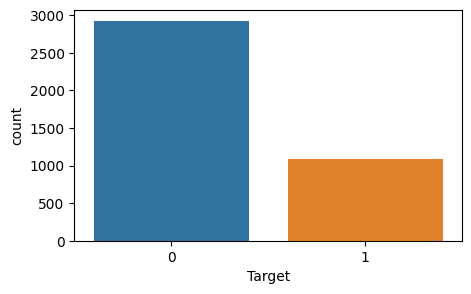

In [6]:
print(train_df['Target'].value_counts())
#
plt.figure(figsize=(5, 3))
sns.countplot(data=train_df, x='Target')
plt.show()

In [7]:
train = train_df.drop('Target', axis=1)
targets = train_df['Target']

train.shape, targets.shape

((4020, 73), (4020,))

In [8]:
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

# scale all columns [0-1]
train = train.iloc[:, :].apply(min_max_scaling)
train.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.000000,1.0,0.0,0.0,1.0,1.0,0.87500,0.363636,0.5,0.12500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.119944,1.0,0.0,0.0,1.0,1.0,0.53125,0.272727,1.0,0.50000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,1.0,0.0,0.0,0.0,1.0,0.75000,0.545455,0.5,0.25000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.227528,0.0,0.0,0.0,0.0,1.0,0.87500,0.000000,0.5,0.12500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.0,0.0,0.0,1.0,1.0,0.81250,1.000000,1.0,0.21875,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### imbalance

In [9]:
train.columns[train.isna().any()].tolist()
# ['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan']

['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan']

In [10]:
train = train.drop(['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan'], axis=1)
train.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.000000,1.0,0.0,0.0,1.0,1.0,0.87500,0.363636,0.5,0.12500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.119944,1.0,0.0,0.0,1.0,1.0,0.53125,0.272727,1.0,0.50000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,1.0,0.0,0.0,0.0,1.0,0.75000,0.545455,0.5,0.25000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.227528,0.0,0.0,0.0,0.0,1.0,0.87500,0.000000,0.5,0.12500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.0,0.0,0.0,1.0,1.0,0.81250,1.000000,1.0,0.21875,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# tl_us = TomekLinks(sampling_strategy='majority')
tl_us = SMOTETomek(random_state=42, sampling_strategy = 1.0)

x_resample,y_resample = tl_us.fit_resample(train, targets )
#
x_resample.shape,y_resample.value_counts()

((5714, 69),
 0    2857
 1    2857
 Name: Target, dtype: int64)

In [12]:
# for i in range(5):
#     x_resample,y_resample = tl_us.fit_resample(x_resample, y_resample )
#     print(f"{y_resample.value_counts()}")


0    2857
1    2857
Name: Target, dtype: int64


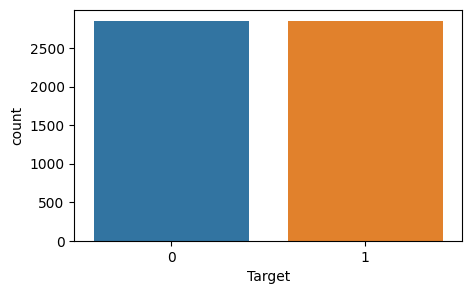

In [13]:
print(y_resample.value_counts())
#
plt.figure(figsize=(5, 3))
sns.countplot(x=y_resample)
plt.show()

#### Feature selection

In [14]:
# pca = PCA(n_components=35)
# train = pca.fit_transform(train)
# train.shape

In [15]:
# lasso = LassoCV()
# lasso.fit(train, targets)
# features = train.columns[lasso.coef_ != 0]
# train = train[features]

In [16]:
# train[features]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=342)

## test data

In [18]:
test_df = pd.read_csv(path_test_data)
test_df = test_df.replace({True: 1, False: 0})
print( f"columns: {len(test_df.columns)}" )
test_df.head()

columns: 73


,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,0,1,2002,12,2022,20,...,0,0,1,0,1,0,0,0,0,0
1,979.0,1.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
2,339.0,0.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
3,0.0,1.0,0.0,0.0,0,1,2002,11,2023,21,...,0,0,1,0,0,0,0,0,0,1
4,613.0,0.0,0.0,0.0,1,1,1993,10,2023,30,...,0,0,1,0,0,0,0,0,0,1


In [19]:
# scale test data [0-1]
test_df = test_df.iloc[:, :].apply(min_max_scaling)
test_df.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.000000,1.0,0.0,0.0,0.0,1.0,0.941176,1.000000,0.5,0.060606,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.270367,1.0,0.0,0.0,1.0,1.0,0.558824,1.000000,1.0,0.484848,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.093621,0.0,0.0,0.0,1.0,1.0,0.558824,1.000000,1.0,0.484848,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,1.0,0.0,0.0,0.0,1.0,0.941176,0.909091,1.0,0.090909,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.169290,0.0,0.0,0.0,1.0,1.0,0.676471,0.818182,1.0,0.363636,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
test_df = test_df.drop(['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan'], axis=1)
test_df.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.000000,1.0,0.0,0.0,0.0,1.0,0.941176,1.000000,0.5,0.060606,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.270367,1.0,0.0,0.0,1.0,1.0,0.558824,1.000000,1.0,0.484848,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.093621,0.0,0.0,0.0,1.0,1.0,0.558824,1.000000,1.0,0.484848,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,1.0,0.0,0.0,0.0,1.0,0.941176,0.909091,1.0,0.090909,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.169290,0.0,0.0,0.0,1.0,1.0,0.676471,0.818182,1.0,0.363636,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# test_df.describe()

In [22]:
# test_df.isnull().sum()

In [23]:
# test_df.corr().head()

#### feature selection

In [24]:
# pca = PCA(n_components=35)
# test_df = pca.fit_transform(test_df)
# test_df.shape

In [25]:
# test_df = test_df[features]

## Model

In [26]:
# df_train = xgb.DMatrix(train, label=targets, enable_categorical=True)

In [27]:
# # for binary classification use: [binary:logistic]
# # multi:softprob

# grid_params = {
#     'objective': ['multi:softmax', 'binary:logistic' ],  # multi:softmax
#     'num_class': [2,],  # number of classes in your dataset
#     'n_estimators': [100, 200, 300, 50],  # number of boosting rounds
#     'learning_rate': [0.001, 1, 0.01, 0.1, 0.2 ], # 1.75 -> works better
#     'max_depth': [5, 4, 5, 6, 7],
#     'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
#     'n_jobs': [0, 1],
#     # 'nthread': -1  # use all available CPU cores
# }

# cls = xgb.XGBClassifier()

# grid_search = GridSearchCV(cls, grid_params, cv=5, scoring='f1')

# grid_search.fit(x_train, y_train)

# print(f"best params: {grid_search.best_params_}")
# print(f"best estimator: {grid_search.best_estimator_}")

In [28]:
# class weights
y_train.value_counts()

1    2295
0    2276
Name: Target, dtype: int64

In [29]:
params = {'learning_rate': 0.2,
          'max_depth': 6,
          'n_estimators': 200,
          'num_class': 2,
          'objective': 'multi:softmax',
}
model = xgb.XGBClassifier(**params)


In [30]:
# # cross validate
# cv = StratifiedKFold(random_state=42, n_splits=100, shuffle=True)
# scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
# print(f"mean score: {scores.mean()}")

In [31]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=2,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [32]:
model.score(x_test, y_test)

0.8862642169728784

In [33]:
y_preds = model.predict(x_test)

In [34]:
f1_score(y_test, y_preds)

0.8807339449541285

In [35]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       581
           1       0.91      0.85      0.88       562

    accuracy                           0.89      1143
   macro avg       0.89      0.89      0.89      1143
weighted avg       0.89      0.89      0.89      1143



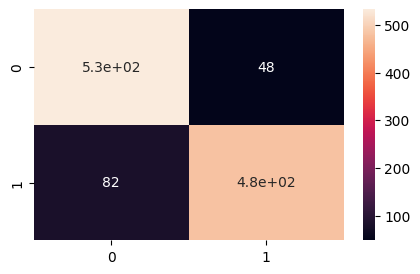

In [36]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.show()

In [37]:
predictions = model.predict(test_df)

In [38]:
test_unclean_df = pd.read_csv(path_data_test)
test_unclean_df.head()

,Person_id,Survey_date,Round,Status,Tenure,Geography,Province,Matric,Degree,Diploma,Schoolquintile,Math,Mathlit,Additional_lang,Home_lang,Science,Female,Sa_citizen,Birthyear,Birthmonth
0,Id_r90136smvl,2022-08-03,3,other,NaN,Urban,KwaZulu-Natal,1.0,0.0,0.0,2.0,0 - 29 %,NaN,50 - 59 %,NaN,40 - 49 %,0,1,2002,12
1,Id_wawdqhmu6s,2023-03-16,4,unemployed,979.0,Urban,Western Cape,1.0,0.0,0.0,NaN,NaN,NaN,40 - 49 %,NaN,NaN,1,1,1989,12
2,Id_ap2czff2bu,2023-03-14,4,unemployed,339.0,Urban,KwaZulu-Natal,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1,1,1989,12
3,Id_uhgink7iha,2023-02-16,4,studying,NaN,Urban,Gauteng,1.0,0.0,0.0,1.0,NaN,80 - 100 %,60 - 69 %,NaN,NaN,0,1,2002,11
4,Id_5j6bzk3k81,2023-03-23,4,unemployed,613.0,Urban,Gauteng,0.0,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,1,1,1993,10


In [39]:
test_unclean_df['Person_id'].isnull().sum()

0

In [42]:
df_submission = pd.DataFrame({"ID": test_unclean_df["Person_id"], "Target": predictions.astype(int)})

In [43]:
df_submission.to_csv("submission.csv", index=False)